In [1]:
# Dependencies
# pip3 install mpld3
# pip3 install casadi
# pip3 install scipy

In [ ]:
import numpy as np
from casadi import *

# Casadi Examples

https://web.casadi.org/docs/#document-ocp

In [2]:
x = MX.sym('x', 2, 2)
y = MX.sym('y')

z = 3 * x + y
print(z)

((3*x)+y)


In [3]:
print(jacobian(sin(z), x))

(zeros(4x4,4nz)[:4] = (all_3(2x2)*cos(((3*x)+y)))[:4])'


In [4]:
x = MX.sym('x')
y = MX.sym('y')
f = Function('x', [x, y], [y + sin(x)])

f(1., 1.)

jf = jacobian(f(x, y), x)
print(jf)

cos(x)


In [5]:
opti = Opti()

x = opti.variable()
y = opti.variable()

z = (x - 1.) ** 2 + y ** 2
opti.minimize(z)
opti.subject_to(x**2 + y**2 == 1)
opti.subject_to(x + y >= 1)

opti.set_initial(x, 0)
opti.set_initial(y, 0)

opti.solver('ipopt')

sol = opti.solve()

print('x: {}, y: {}, z: {}'.format(sol.value(x), sol.value(y), sol.value(z)))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

# Let's create a race car!!!

Inspired by CasADi usage examples

https://web.casadi.org/blog/ocp/


In [6]:
from casadi import *
from pylab import plot, step, figure, legend, show, spy
import matplotlib.pyplot as plt
import math

In [7]:
# choose a car
friction_acc = 6.

a_min = -5.
a_max = 3.


# TODO: add constraint on friction instead of constraint on normal acceleration
a_n_max = (friction_acc**2 - a_min**2) ** 0.5
print(a_n_max)

a_n_min = -a_n_max

c_max = 0.2
c_min = -0.2

vehicle_width = 2.0
vehicle_length = 4.0
vehicle_back_to_axis = 1.0

3.3166247903554


In [8]:
# create a race track
Length = 250.
road_width = 10.
road_period = 35.
road_amplitude = 24.

# TODO: remove magic margin and process borders accurately
margin = vehicle_length - vehicle_back_to_axis

def road_center(x):
    return (cos(x / road_period) - 1) * road_amplitude

def road_curvature(x):
    # curvature of A * cos(x / T)
    A = road_amplitude
    T = road_period
    
    d = sqrt((A**2 * sin(x/T) ** 2)/T**2 + 1)
    l = ((A * cos(x/T))/((T**2 + A**2*sin(x/T)**2) * sqrt((A**2 * sin(x/T)**2)/T**2 + 1)))**2
    r = 1/4 * ((A**2 * sin((2 * x)/T))/(T**3 * ((A**2 * sin(x/T)**2)/T**2 + 1)**(3/2)))**2
    return sqrt(l + r) / d

def road_yaw(x):
    return - sin(x / road_period) * road_amplitude / road_period

def top_border(x, shift=0.):
    return road_center(x) + road_width / 2. + shift

def bottom_border(x, shift=0.):
    return road_center(x) - road_width / 2. + shift

In [9]:
# number of points in trajectory
N = 100

In [10]:
# Baseline solution
x_uniform = np.arange(N + 1) * Length / N
max_curvature = max(abs(np.array(road_curvature(x_uniform))))
v_max = math.sqrt(a_n_max / max_curvature)


# baseline solution - accelerate till max allowed speed limit and
# keep driving with it
t_acc = v_max / a_max
T_baseline = t_acc + (Length - t_acc ** 2 / 2) / v_max

print('''Baseline time is {0:.3f} sec.'''.format(T_baseline))

Baseline time is 22.829 sec.


In [11]:
# create a race car planner!
opti = Opti()

# X = {x, y, yaw, v}
X = opti.variable(4, N + 1)
x_id, y_id, yaw_id, v_id = 0, 1, 2, 3

# U = {a, c}
a_id, c_id = 0, 1
U = opti.variable(2, N)

T = opti.variable()

opti.minimize(T)

In [12]:
# define system equation constraints
def system_equation(X, U):
    speed = X[v_id]
    yaw = X[yaw_id]
    derivatives = vertcat(
        speed * cos(yaw),
        speed * sin(yaw),
        speed * U[c_id],
        U[a_id]
    )
    return derivatives

dt = T / N
for i in range(N):
    # just Euler method
    x_next = X[:, i] + system_equation(X[:, i], U[:, i]) * dt
    opti.subject_to(X[:, i + 1] == x_next)

opti.subject_to(X[v_id, :] >= 0)

# start and finish constraints
opti.subject_to(X[:, 0] == [0., 0., 0., 0.])
opti.subject_to(X[x_id, -1] == Length)

# improve stability
opti.subject_to(X[y_id, -1] == road_center(Length))
opti.subject_to(X[yaw_id, -1] == road_yaw(Length))


# control constraints
opti.subject_to(U[a_id, :] <= a_max)
opti.subject_to(U[a_id, :] >= a_min)

opti.subject_to(U[c_id, :] <= c_max)
opti.subject_to(U[c_id, :] >= c_min)

# normal acc. constraint
opti.subject_to(U[c_id, :] * X[v_id, :-1] ** 2 <= a_n_max)
opti.subject_to(U[c_id, :] * X[v_id, :-1] ** 2 >= a_n_min)

# road border constraints
opti.subject_to(X[y_id, :] <= top_border(X[x_id, :]) - margin)
opti.subject_to(X[y_id, :] >= bottom_border(X[x_id, :]) + margin)

# time constraint
opti.subject_to(T >= 0.)

In [13]:
# prepare initial trivial solution - race slowly in the middle in the track
v_init = v_max
T_init = Length / v_init
x_init = v_init * np.arange(N + 1) * T_init / N

opti.set_initial(T, T_init)
opti.set_initial(X[v_id, :], v_init)
opti.set_initial(X[x_id, :], x_init)
opti.set_initial(X[y_id, :], road_center(x_init))

In [14]:
# Solve
opti.solver('ipopt')
solution = opti.solve()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1907
Number of nonzeros in inequality constraint Jacobian.:     1306
Number of nonzeros in Lagrangian Hessian.............:      901

Total number of variables............................:      605
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      407
Total number of inequality constraints...............:      904
        inequality constraints with only lower bounds:      402
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      502

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [15]:
def rotation_matrix(yaw):
    return np.array([[cos(yaw), -sin(yaw)], [sin(yaw), cos(yaw)]])

Congratulations, you completed the race!!!
Your track time is 18.396 sec., baseline time is 22.829 sec.


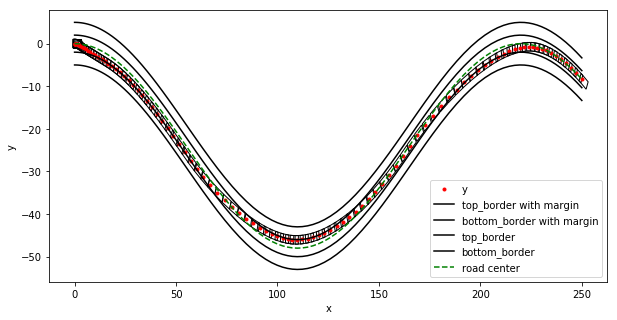

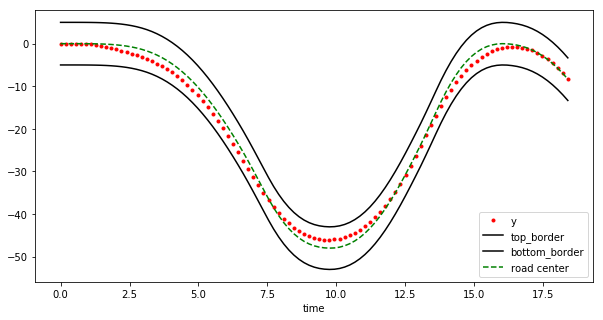

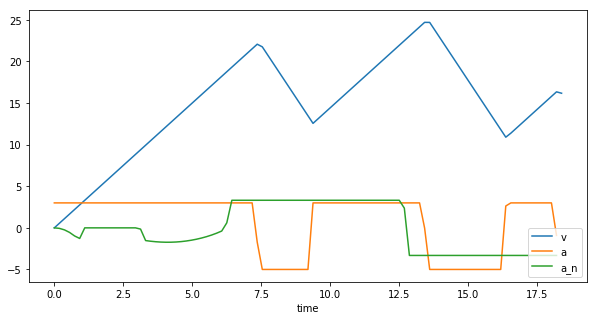

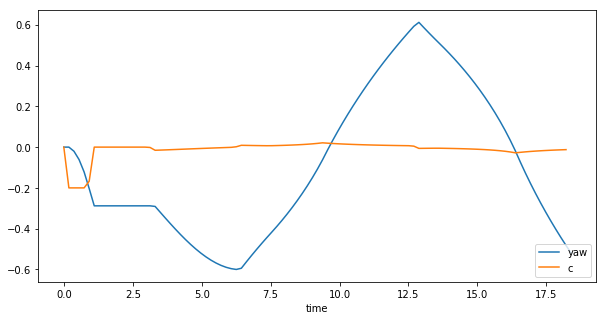

In [16]:
# plot solution

import mpld3
%matplotlib inline
mpld3.enable_notebook()
plt.rcParams["figure.figsize"] = [10, 5]

x_s = solution.value(X[x_id, :])
y_s = solution.value(X[y_id, :])
v_s = solution.value(X[v_id, :])

yaw_s = solution.value(X[yaw_id, :])
c_s = solution.value(U[c_id, :])
a_s = solution.value(U[a_id, :])
T_s = solution.value(T)
t_u = np.arange(N + 1) * T_s / N

print('''Congratulations, you completed the race!!!
Your track time is {0:.3f} sec., baseline time is {1:.3f} sec.'''.format(T_s, T_baseline))


plot(x_s, y_s, 'r.', label='y')
plot(x_s, top_border(x_s, -margin), 'k-', label='top_border with margin')
plot(x_s, bottom_border(x_s, +margin), 'k-', label='bottom_border with margin')
plot(x_s, top_border(x_s), 'k-', label='top_border')
plot(x_s, bottom_border(x_s), 'k-', label='bottom_border')
plot(x_s, road_center(x_s), 'g--', label='road center')
plt.xlabel('x')
plt.ylabel('y')


for x, y, yaw in zip(x_s, y_s, yaw_s):
    center = np.array([[x], [y]]) + rotation_matrix(yaw).dot(np.array([[-vehicle_back_to_axis], [-vehicle_width/2]]))
    rect = plt.Rectangle(center, vehicle_length, vehicle_width, angle=math.degrees(yaw), facecolor='none', linewidth=1, edgecolor='k')
    plt.gca().add_patch(rect)
legend(loc='lower right')

figure()
plot(t_u, y_s, 'r.', label='y')
plot(t_u, top_border(x_s), 'k-', label='top_border')
plot(t_u, bottom_border(x_s), 'k-', label='bottom_border')
plot(t_u, road_center(x_s), 'g--', label='road center')
plt.xlabel('time')
legend(loc='lower right')

figure()
# plot(x_s, label='x')
plot(t_u, v_s, label='v')
plot(t_u[:-1], a_s, label='a')
plot(t_u[:-1], c_s * v_s[:-1] ** 2, label='a_n')
plt.xlabel('time')
legend(loc='lower right')

figure()
plot(t_u, yaw_s, label='yaw')
plot(t_u[:-1], c_s, label='c')
plt.xlabel('time')
legend(loc='lower right')

show()



Text(0,0.5,'constraints')

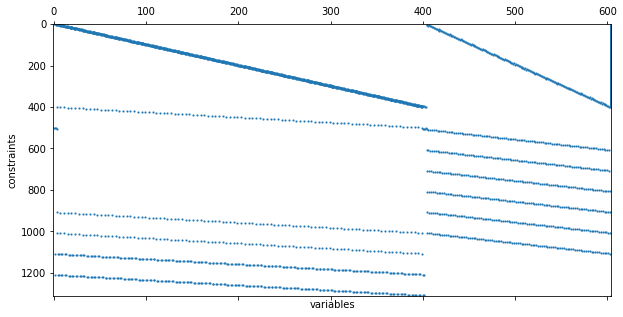

In [17]:
# jacobian and hessian are very sparse in this kind of tasks.

spy(solution.value(jacobian(opti.g, opti.x)), aspect='auto', markersize=1.)

plt.xlabel('variables')
plt.ylabel('constraints')

**Home assignment**

В примере на семинаре было сделано несколько допущений, улучшив которые, вы можете построить более быструю траекторию.

* Уточнить ограничение на нормальное и тангенциальное ускорение. (2 балла)

Нормальное и тангенциальное ускорение нужно выбирать таким, чтобы результирующий вектор ускорения не превышал силу трения.

Результирующее ускорение считается как векторная сумма нормального и тангенциального ускорения.

`a ** 2 = a_n ** 2 + a_t ** 2`

То есть лимит a_min, a_n_max, a_n_min надо заменить на лимит по friction_acc.
Лимит a_max при этом остаётся, так как это свойство двигателя.

**В отчёт** надо добавить график величины результирующего ускорения.


* Уточнить проверку границы дороги (4 балла)

На семинаре мы отступили по 3 метра от границы дороги. 
В домашнем задании вам предстоит написать более точную проверку, 
что позволит автомобилю использовать всё свободное пространство.

Подсказка: один из вариантов реализации это проверка, что углы прямоугольника находятся внутри дорожного полотна.

**В отчёте** должен быть график, показывающий границы дороги и габариты автомобиля. График с семинара подходит.

* Объезд препятствия (4 балла)

В качестве препятствия выбираем окружность радиусом 1 м. X,Y выбираем так, чтобы препятствие было расположено на траектории движения автомобиля.

Реализуйте ограничение на отсутствие коллизий с препятствием. 

**В отчёт** приложите график, на котором автомобиль изначально проезжает сквозь препятствие.
После реализации ограничений объезжает препятствие. Если для проверки коллизий будете использовать аппроксимацию окружностями(см. ниже), то приложите график, визуализирующий как окружности накрывают габариты автомобиля.

Для визуализации препятствия можете использовать matplotlib.Circle
```
obstacle = plt.Circle(xy=(obstacle_x, obstacle_y), radius=obstacle_r)
plt.gca().add_patch(obstacle)
```

Подсказка: Один из вариантов реализации это аппроксимация автомобиля набором окружностей.
Тогда ограничение на отсутствие коллизий выражается в то, что расстояние от центра препятствия до центра каждой окружности автомобиля должно быть больше, чем сумма радиусов.

<img src="files/car_approximation.png">
